In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tushare as ts
import datetime
import dateutil
import os
import pickle
ts.set_token('e32fe83c30637d56260e179d663c8881c1a9af62a1bf5518a20627bb')
pro = ts.pro_api()

# trade_cal = pro.trade_cal()
# trade_cal.to_csv("trade_cal.csv")
trade_cal = pd.read_csv("trade_cal.csv", index_col=0, parse_dates=["cal_date"]) # trading calendar

CASH = 10000000 
START_DATE = '2018-01-01'
END_DATE = '2022-01-01'

class Context:
    def __init__(self, cash, start_date, end_date):
        self.cash = cash # 初始资金
        self.start_date = start_date # 回测开始日期
        self.end_date = end_date # 回测结束日期
        self.positions = {} # 持仓
        self.benchmark = None # 基准
        self.date_range = trade_cal[(trade_cal["is_open"] == 1)
                                    &(trade_cal["cal_date"] >= start_date)
                                    &(trade_cal["cal_date"] <= end_date)]['cal_date'] # 回测日期范围
        self.dt = dateutil.parser.parse(start_date) # 类型是datetime, TODO: start_date 后一个交易日
        self.data = {} # 用于存储数据
        
context = Context(CASH, START_DATE, END_DATE)   
# print(trade_cal)
        
def find_trading_date(date, previous=True):
    if previous:
        return trade_cal[(trade_cal["is_open"] == 1)
                         &(trade_cal["cal_date"] <= date)]["cal_date"].iloc[-1]
    else:
        return trade_cal[(trade_cal["is_open"] == 1)
                         &(trade_cal["cal_date"] >= date)]["cal_date"].iloc[0]
class G:
    pass 

g = G()


def attribute_daterange_history(security, start_date, end_date, fields=['open','close','high','low','vol']):
    # df = pd.read_csv(security+".csv", index_col='date', parse_dates=["date"])
    # 寻找最近的交易日
    start_date, end_date = find_trading_date(start_date, previous=False), find_trading_date(end_date, previous=True)
    if isinstance(start_date, datetime.datetime):
        start_date = start_date.strftime("%Y-%m-%d")
    if isinstance(end_date, datetime.datetime):
        end_date = end_date.strftime("%Y-%m-%d")
    start_date = start_date.replace("-", "")
    end_date = end_date.replace("-", "")
    if security not in context.data or context.data[security].index[0] > start_date or context.data[security].index[-1] < end_date: # 从context.data中读取数据，如果日期不在范围内，则重新下载
        if not os.path.exists("prices"):
            os.mkdir("prices")
        name = f'prices/{security}.pkl'
        if os.path.exists(name):
            print("%s数据在本地已存在，读取本地数据" % security)
            with open(name, 'rb') as f:
                df = pickle.load(f)

        if not os.path.exists(name) or len(df) == 0 or df.index[0] > start_date or df.index[-1] < end_date:
            print("%s数据开始下载" % security)
            df = pro.daily(ts_code=security, start_date=start_date, end_date=end_date).set_index('trade_date')[fields][::-1] # 从tushare下载数据, 日期升序
            print("%s数据下载完毕" % security)
            with open(name, 'wb') as f:
                pickle.dump(df, f)
            
        context.data[security] = df # 将数据存入context.data
    
    return context.data[security].loc[start_date:end_date]


def attribute_history(security, count, fields=['open','close','high','low','vol']):
    end_date = context.dt - datetime.timedelta(days=1)
    start_date = trade_cal[(trade_cal["is_open"] == 1) & (trade_cal["cal_date"] <= end_date)]["cal_date"].iloc[-count]  
    print(start_date, end_date) 
    # df = pro.daily(ts_code=security, start_date=context.date_range[-count], end_date=context.date_range[-1])
    # df = df.set_index("trade_date")
    # return df[fields]
    return attribute_daterange_history(security, start_date, end_date, fields)
# SYMBOL = '000001.SZ'
# attribute_daterange_history(SYMBOL, START_DATE, END_DATE)
from yfinance import download


def get_today_data(security):
    today = context.dt.strftime('%Y-%m-%d').replace('-', '')
    if security in context.data:
        data = context.data[security]
    else:
        print("%s不在缓存中" % security)
        data = attribute_daterange_history(security, START_DATE, END_DATE)
    if today in data.index:
        return data.loc[today]
    else:
        return []


def _order(today_data, security, amount):
    if len(today_data) == 0:
        print("今日停牌")
        return 
    
    if security not in context.positions:
        context.positions[security] = 0
    
    p = today_data['open']
    if context.cash - amount * p < 0:
        amount = int(context.cash / p)
        print("现金不足")
    
    # 买入的时候必须是100的整数倍，卖出的时候可以全仓卖出
    if amount % 100 != 0 and amount != -context.positions[security]:
        amount = np.sign(amount) * (abs(amount) // 100) * 100
        print("不是100的倍数，已调整为", amount)
    
    # 卖出股票不能超过持仓数量
    if context.positions[security] < -amount:
        amount = -context.positions[security]
        print('卖出股票不能超过持仓数量，已调整为', amount)
    
    context.positions[security] += amount
    context.cash -= amount * p
    
    if context.positions[security] == 0:
        del context.positions[security]
    
# _order(get_today_data(SYMBOL), SYMBOL, 3923)
    
def order(security, amount):
    today_data = get_today_data(security)
    if len(today_data) == 0:
        print("今日停牌")
        return
    return _order(today_data, security, amount)

def order_target(security, amount):
    if amount < 0:
        print("数量不能小于0，已经调成为0")
        amount = 0
        
    today_data = get_today_data(security)
    if len(today_data) == 0:
        print("今日停牌")
        return
    if security not in context.positions:
        context.positions[security] = 0 # ToDo: T+1 closable total
    hold_amount = context.positions[security]
    delta_amount = amount - hold_amount
    _order(today_data, security, delta_amount)

def order_value(security, value):
    today_data = get_today_data(security)
    if len(today_data) == 0:
        print("今日停牌")
        return
    amount = int(value / today_data['open'])
    _order(today_data, security, amount)

def order_target_value(security, value):
    if value < 0:
        print("价格不能小于0，已经调成为0")
        value = 0
    today_data = get_today_data(security)
    if len(today_data) == 0:
        print("今日停牌")
        return
    if security not in context.positions:
        context.positions[security] = 0 # ToDo: T+1 closable total
    hold_value = context.positions[security] * today_data['open']
    delta_value = value - hold_value
    order_value(security, delta_value)
    

# SYMBOL2 = '601318.SH'
# order(SYMBOL2, 1000)
# order_value(SYMBOL2, 50000)
# attribute_daterange_history(SYMBOL2, START_DATE, END_DATE)
# print(context.positions)
# print(context.cash)
def set_benchmark(security):
    context.benchmark = security

def subtract_one_year(date):
    date = datetime.datetime.strptime(date, '%Y-%m-%d')
    return date - datetime.timedelta(days=365)

In [19]:
SYMBOL = '000006.SZ'
SYMBOL2 = '000002.SZ'
BENCHMARK = '600519.SH'
context = Context(CASH, START_DATE, END_DATE) 
def initialize(context):
    set_benchmark(BENCHMARK)
    g.p1 = 5
    g.p2 = 60
    g.security = SYMBOL
    # download data from tushare to speed up the process
    attribute_daterange_history(SYMBOL, subtract_one_year(START_DATE), END_DATE)
    # attribute_daterange_history(SYMBOL2, START_DATE, END_DATE)
    pass 

def handle_data(context):
    # order_value(SYMBOL, 10000)
    # order(SYMBOL2, 800)
    # order_value(SYMBOL2, -5000)
    hist = attribute_history(g.security, g.p2)
    ma5 = hist['close'].iloc[g.p1:].mean()
    ma60 = hist['close'].mean()
    
    if ma5 > ma60 and g.security not in context.positions:
        order_value(g.security, context.cash)
    elif ma5 < ma60 and g.security in context.positions:
        order_target(g.security, 0)
        

def run():
    plt_df = pd.DataFrame(index=pd.to_datetime(context.date_range), columns=['value'])
    initialize(context)
    last_price = {}
    for dt in context.date_range:
        # context.dt = dateutil.parser.parse(dt) # 转换成datetime
        context.dt = dt # 已经是datetime不需要转换
        handle_data(context) # 下单
        value = context.cash # 资金
        for stock in context.positions:
            # TODO: 主要获取价格的速度要快
            today_data = get_today_data(stock) # 获取当天的价格
            if len(today_data) == 0:
                print("今日停牌")
                p = last_price.get(stock, 0) # ToDo: 可能没有上一个交易日的价格
            else:
                p = today_data['close']
                last_price[stock] = p
            value += context.positions[stock] * p
        plt_df.loc[dt, 'value'] = value # 这种方法比较慢
    # print(plt_df)
    plt_df["ratio"] = plt_df["value"] / plt_df["value"].iloc[0] - 1
    bm_df = attribute_daterange_history(context.benchmark, context.start_date, context.end_date)
    benchmark_ratio = bm_df["open"] / bm_df['open'].iloc[0] - 1
    benchmark_ratio.name = "benchmark_ratio"
    benchmark_ratio.index = pd.to_datetime(benchmark_ratio.index)
    plt_df = plt_df.join(benchmark_ratio).fillna(method='ffill')
    plt_df[["ratio", "benchmark_ratio"]].plot()
    plt.show()
    return plt_df
    


000006.SZ数据开始下载
000006.SZ数据下载完毕
2017-10-09 00:00:00 2018-01-01 00:00:00
2017-10-10 00:00:00 2018-01-02 00:00:00
2017-10-11 00:00:00 2018-01-03 00:00:00
2017-10-12 00:00:00 2018-01-04 00:00:00
2017-10-13 00:00:00 2018-01-07 00:00:00
2017-10-16 00:00:00 2018-01-08 00:00:00
2017-10-17 00:00:00 2018-01-09 00:00:00
2017-10-18 00:00:00 2018-01-10 00:00:00
2017-10-19 00:00:00 2018-01-11 00:00:00
2017-10-20 00:00:00 2018-01-14 00:00:00
2017-10-23 00:00:00 2018-01-15 00:00:00
2017-10-24 00:00:00 2018-01-16 00:00:00
2017-10-25 00:00:00 2018-01-17 00:00:00
2017-10-26 00:00:00 2018-01-18 00:00:00
2017-10-27 00:00:00 2018-01-21 00:00:00
2017-10-30 00:00:00 2018-01-22 00:00:00
2017-10-31 00:00:00 2018-01-23 00:00:00
2017-11-01 00:00:00 2018-01-24 00:00:00
2017-11-02 00:00:00 2018-01-25 00:00:00
2017-11-03 00:00:00 2018-01-28 00:00:00
2017-11-06 00:00:00 2018-01-29 00:00:00
2017-11-07 00:00:00 2018-01-30 00:00:00
2017-11-08 00:00:00 2018-01-31 00:00:00
2017-11-09 00:00:00 2018-02-01 00:00:00
2017-11-

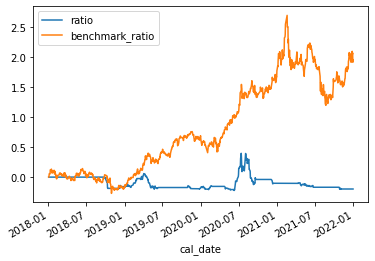

,value,ratio,benchmark_ratio
cal_date,,,
2018-01-02,10000000.0,0.000000,0.000000
2018-01-03,10000000.0,0.000000,0.002143
2018-01-04,10000000.0,0.000000,0.030571
2018-01-05,10000000.0,0.000000,0.058571
2018-01-08,10000000.0,0.000000,0.050029
...,...,...,...
2021-12-27,8017460.0,-0.198254,2.097143
2021-12-28,8017460.0,-0.198254,2.047143
2021-12-29,8017460.0,-0.198254,2.071429


In [20]:
plt_df = run()
plt_df